In [1]:
#### IAU Project Phase 3 - Machine Learning
#### Andrej Horváth / Adam Partl
#### Share of work : 50% / 50%

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.svm import SVC

from collections import Counter

### First we prepare the data, the same way we did in the previous phase

In [3]:
connections_df = pd.read_csv('data/connections.csv',delimiter='\t', on_bad_lines='skip')
processes_df = pd.read_csv('data/processes.csv',delimiter='\t', on_bad_lines='skip')
merged_df = pd.merge(connections_df, processes_df, on=['ts', 'imei'], how='inner')
merged_df = merged_df.drop(columns=['mwra_y']).rename(columns={'mwra_x': 'mwra'})
X = merged_df.drop(columns=['mwra', 'ts', 'imei'])
y = merged_df['mwra']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

Here we declare a function to handle outliers, that can be then used in the pipeline.

In [ ]:
class HandleOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.3, upper_quantile=0.7):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.quantile_bounds_ = {}
        numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
        
        for col in numeric_columns:
            Q1 = X[col].quantile(self.lower_quantile)
            Q2 = X[col].quantile(self.upper_quantile)
            IQR = Q2 - Q1
            self.quantile_bounds_[col] = {
                'lower_bound': Q1 - 1.5 * IQR,
                'upper_bound': Q2 + 1.5 * IQR
            }
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

        for col in numeric_columns:
            if col not in self.quantile_bounds_:
                continue  
            bounds = self.quantile_bounds_[col]
            mean_value = X[col].mean()
            
            X[col] = np.where(X[col] < bounds['lower_bound'], mean_value, 
                              np.where(X[col] > bounds['upper_bound'], mean_value, X[col]))
        return X.values

### 3.1 a)

We make a ID3 classifier with max deapth of 3

First we make a tree class as nodes for the decision tree.

We also define prediction functions.

In [69]:
class tree():
    def __init__(self,index=None, threashold=None, left=None, right=None, label=None, info_gain=None):
        self.index = index
        self.threshold = threashold
        self.left = left
        self.right = right
        self.label = label
        self.info_gain = info_gain

    def predict_single(self, x):
        if self.label is not None:
            return self.label
        if x[self.index] <= self.threshold:
            return self.left.predict_single(x)
        else:
            return self.right.predict_single(x)

# Predict for a batch of data points
    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])

In [ ]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

def information_gain(y, left_y, right_y):
    p = len(left_y) / len(y)
    return entropy(y) - (p * entropy(left_y) + (1 - p) * entropy(right_y))

def build_tree(X, y,depth=0,max_depth=None):
    n_samples, n_features = X.shape
    unique_classes = np.unique(y)
    # Stop splitting if all labels are the same or max depth is reached
    if len(unique_classes) == 1 or n_samples == 0 or (max_depth is not None and depth >= max_depth):
        majority_class = np.bincount(y.astype(int)).argmax() if n_samples > 0 else None
        return tree(label=majority_class)

    best_gain = -1
    best_index = None
    best_threshold = None
    best_splits = None

    for index in range(n_features):
        thresholds = np.unique(X[:, index])
        for threshold in thresholds:
            left_mask = X[:, index] <= threshold
            right_mask = ~left_mask
            left_y, right_y = y[left_mask], y[right_mask]

            if len(left_y) > 0 and len(right_y) > 0:
                gain = information_gain(y, left_y, right_y)
                if gain > best_gain:
                    best_gain = gain
                    best_index = index
                    best_threshold = threshold
                    best_splits = (left_mask, right_mask)

    # If no split improves information gain, create a leaf node
    if best_gain == -1:
        majority_class = np.bincount(y).argmax()
        return tree(label=majority_class)

    left_tree = build_tree(X[best_splits[0]], y[best_splits[0]], depth=depth + 1, max_depth=max_depth)
    right_tree = build_tree(X[best_splits[1]], y[best_splits[1]], depth=depth + 1, max_depth=max_depth)

    return tree(index=best_index, threashold=best_threshold, left=left_tree, right=right_tree, info_gain=best_gain)

# Build the tree
decision_tree = build_tree(X_train.to_numpy(), y_train.to_numpy(),max_depth=3)

Feature 0 <= 11.1776, Gain: 0.2347
|  Feature 2 <= 9.19153, Gain: 0.1216
|  |  Feature 11 <= 9.61168, Gain: 0.2587
|  |  |  Leaf: 1
|  |  |  Leaf: 0
|  |  Feature 11 <= 12.83673, Gain: 0.0406
|  |  |  Leaf: 1
|  |  |  Leaf: 0
|  Feature 11 <= 9.48432, Gain: 0.1449
|  |  Feature 2 <= 9.89969, Gain: 0.3158
|  |  |  Leaf: 0
|  |  |  Leaf: 1
|  |  Feature 4 <= 8.76339, Gain: 0.0449
|  |  |  Leaf: 0
|  |  |  Leaf: 0


After fiting the decison tree we start testing with the test data. We use sklearn functions to get accuracy, precision and recall scores.

In [76]:
ID3_test = decision_tree.predict(X_test.to_numpy())

ID3_train = decision_tree.predict(X_train.to_numpy())

print("scores for train data",accuracy_score(y_train,ID3_train),precision_score(y_train,ID3_train),recall_score(y_train,ID3_train))
print("scores for test data",accuracy_score(y_test,ID3_test),precision_score(y_test,ID3_test),recall_score(y_test,ID3_test))

scores for train data 0.8763662861306777 0.8941295803220489 0.9106404958677686
scores for test data 0.8847150259067358 0.9036999493157628 0.9148281169830682


By calculating the scores for training and test data we can see that they perform roughly the same. We can conclude that our decision tree is not overfited.

### 3.2 a)
We use one tree algorithm for classification, which will be Random Forest
### 3.2 b)
We use one non-tree algoritm for classification ,which will be Logistic Regression.

We use both models in the pipeline we built in phase 2, and evaluate them on accuracy.

In [4]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_treatment', HandleOutliers(lower_quantile=0.3, upper_quantile=0.7)),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')),    
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Create a full pipeline with the preprocessor and feature selection
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),  # Feature selection
    ('classifier', LogisticRegression(max_iter=200))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),  # Feature selection
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])

# Fit the pipeline to the training data
logreg_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Evaluate the model
logreg_train_score = logreg_pipeline.score(X_train, y_train)
logreg_test_predictions = logreg_pipeline.predict(X_test)
logreg_test_accuracy = accuracy_score(y_test, logreg_test_predictions)
rf_train_score = rf_pipeline.score(X_train, y_train)
rf_test_predictions = rf_pipeline.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)

print("Logistic Regression Evaluation:")
print(logreg_train_score, logreg_test_accuracy)
print("Random Forest Evaluation:")
print(rf_train_score, rf_test_accuracy)


Logistic Regression Evaluation:
0.8978220387013197 0.9077072538860104 0.9486916367367881
Random Forest Evaluation:
0.8949882600599142 0.8889248704663213 0.9384299640841457


From the training we can see that the accuracy between Logistic Regression and Random Forest is very close, but Logistic regression performs better.

### 3.2 d) 
We can visualize a single decision tree from the Random Forest Classifier.


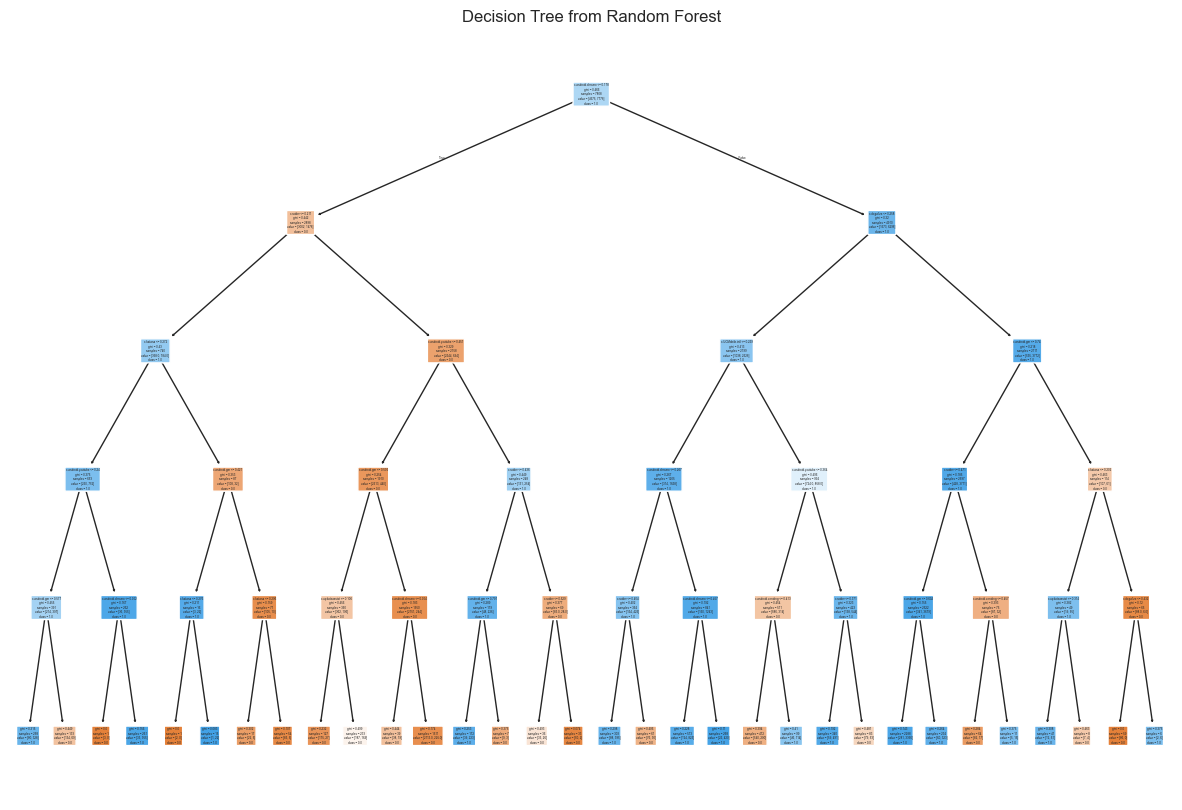

In [25]:
single_tree = rf_pipeline.named_steps['classifier'].estimators_[0]
plt.figure(figsize=(15, 10))
plot_tree(single_tree, 
          feature_names=X_train.columns, 
          class_names=rf_pipeline.named_steps['classifier'].classes_.astype(str), 
          filled=True, rounded=True)
plt.title("Decision Tree from Random Forest")
plt.show()

Since the tree is too large, and unreadable we can limit its depth to 3.

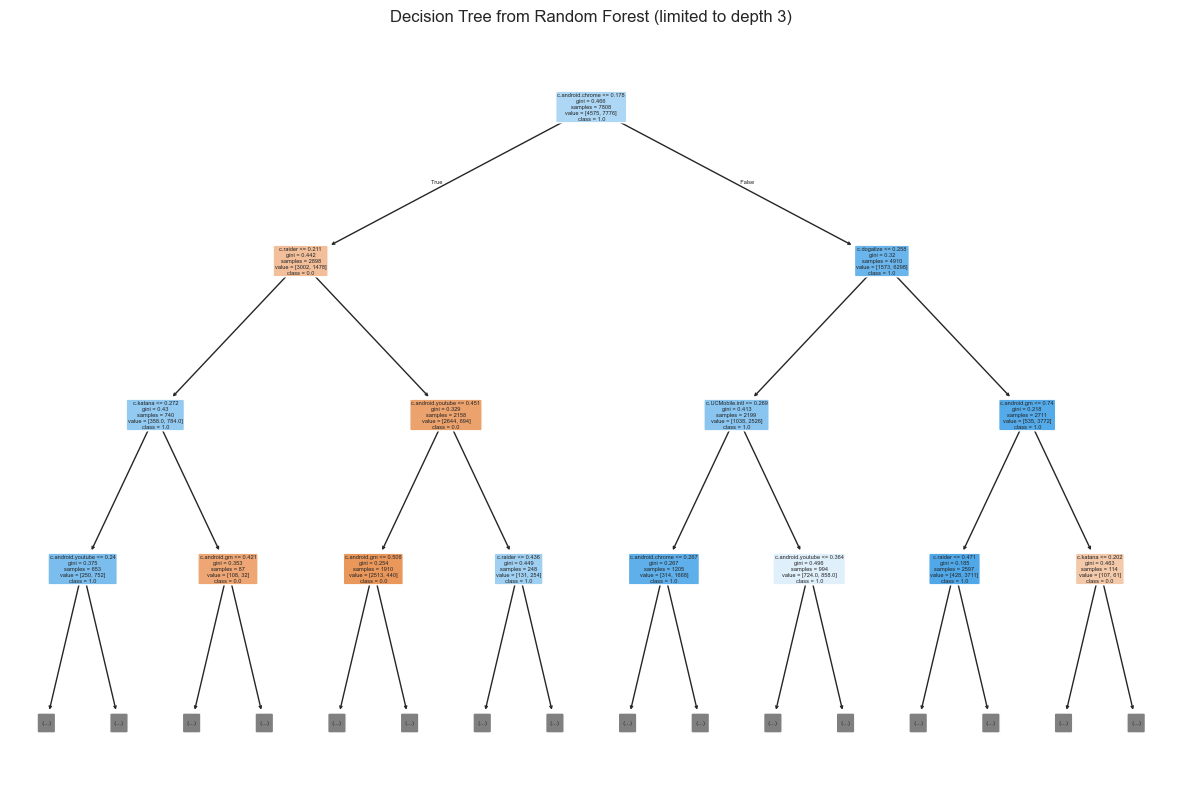

In [27]:
plt.figure(figsize=(15, 10))
plot_tree(single_tree, 
          feature_names=X_train.columns, 
          class_names=rf_pipeline.named_steps['classifier'].classes_.astype(str), 
          filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree from Random Forest (limited to depth 3)")
plt.show()

### 3.2 E)
We evaluate the models further with classification reports to see the precision, recall and F1 score

In [14]:
train_predictions = rf_pipeline.predict(X_train)
print("Training Classification Report for Random Forest:\n", classification_report(y_train, train_predictions))
test_predictions = rf_pipeline.predict(X_test)
print("Test Classification Report for Random Forest:\n", classification_report(y_test, test_predictions))

Training Classification Report for Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.89      0.82      0.85      4607
         1.0       0.90      0.94      0.92      7744

    accuracy                           0.89     12351
   macro avg       0.89      0.88      0.89     12351
weighted avg       0.89      0.89      0.89     12351

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.80      0.84      1139
         1.0       0.89      0.94      0.91      1949

    accuracy                           0.89      3088
   macro avg       0.89      0.87      0.88      3088
weighted avg       0.89      0.89      0.89      3088


In [15]:
train_predictions = logreg_pipeline.predict(X_train)
print("Training Classification Report for Logistic Regression:\n", classification_report(y_train, train_predictions))
test_predictions = logreg_pipeline.predict(X_test)
print("Test Classification Report Logistic Regression:\n", classification_report(y_test, test_predictions))

Training Classification Report for Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      4607
         1.0       0.90      0.94      0.92      7744

    accuracy                           0.90     12351
   macro avg       0.90      0.88      0.89     12351
weighted avg       0.90      0.90      0.90     12351

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.84      0.87      1139
         1.0       0.91      0.95      0.93      1949

    accuracy                           0.91      3088
   macro avg       0.91      0.89      0.90      3088
weighted avg       0.91      0.91      0.91      3088


Based on the results of the classification reports we can say:
Logistic Regression performs slightly better in terms of accuracy, both on training and testing data.
Logistic Regression has better precision for both classes.
Logistic Regression has better recall for class 0, and both models perform similarly in terms of recall for class 1, yet Logistic Regression still performs slightly better.
Logistic Regression has higher F1-scores for both classes, which indicates that it is better at balancing false positives and negatives.
In Logistic Regression. test metrics closely match the training metrics, which suggests that the model does not overfit. For the Random Forest model the performance is slightly lower.

### 3.3 Optimization

Now we can proceed with hyperparameter tuning.
We can see from the original models that Logistic Regression seems to perform better than Random Forests. This is why we choose to proceed with hyperparameter tuning for Logistic Regression.

### 3.3 a)
The Hyperparameters we can tune are `C` (regularization strength), `penalty` (Type of regularization), `solver` (Optimization algorithm)
We use grid search to find the best performing hyperparameters based on accuracy.
Additionally, we use 5-fold cross validation.
We specifically comment out the polynomial transformation to save execution time.

In [18]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_treatment', HandleOutliers(lower_quantile=0.3, upper_quantile=0.7)),
    ('scaler', MinMaxScaler()),
    #('poly', PolynomialFeatures(degree=2)),
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')),    
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Create a full pipeline with the preprocessor and feature selection
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),  # Feature selection
    ('classifier', LogisticRegression(max_iter=200, random_state=78))
])

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Grid search for Logistic Regression
grid_search_lr = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_lr,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search_lr.fit(X_train, y_train)
print("Logistic Regression Best Parameters:", grid_search_lr.best_params_)
print("Best Accuracy:", grid_search_lr.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Logistic Regression Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Accuracy: 0.8953932008054567


From the results we can see the best parameters, and we can build the pipeline using these parameters with polynomial transformation.

In [8]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_treatment', HandleOutliers(lower_quantile=0.3, upper_quantile=0.7)),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')),    
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Create a full pipeline with the preprocessor and feature selection
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),  # Feature selection
    ('classifier', LogisticRegression(max_iter=200, C=1, penalty='l2', solver='liblinear'))
])


# Fit the pipeline to the training data
logreg_pipeline.fit(X_train, y_train)

# Evaluate the model
logreg_train_score = logreg_pipeline.score(X_train, y_train)
logreg_test_predictions = logreg_pipeline.predict(X_test)
logreg_test_accuracy = accuracy_score(y_test, logreg_test_predictions)


print("Logistic Regression Evaluation:")
print(logreg_train_score, logreg_test_accuracy)

Logistic Regression Evaluation:
0.8979839689094 0.9077072538860104


We can see small increase of accuracy from the pipeline that contains tuned parameters.
Additionally, we can verify that there is not underfit, since training accuracy is 0.898 and test accuracy is 0.908

In the next step, we want to create an ensemble of models to optimize performance. This requires us to use another model. We chose to use SVM. Before we create the ensemble of the model, we will create a pipeline with hyperparameter tuning for the SVM classifier, to find the best performing parameters.
With SVM, we can do hyperparameter tuning on `C`, `kernel`, and `gamma`.
We will also specifically not use the polynomial transformation to save execution time.
And we use a grid search with 3-fold cross validation (to save execution time).

In [20]:
# Numerical and categorical feature selection
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Pipelines for preprocessing
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

### SVM Pipeline
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),
    ('classifier', SVC())
])

param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit SVM
grid_search_svm.fit(X_train, y_train)
print("SVM Best Parameters:", grid_search_svm.best_params_)
print("SVM Best Accuracy:", grid_search_svm.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
SVM Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
SVM Best Accuracy: 0.922921220953769


With the results of the tuning we can use them on a pipeline with the polynomial transformation.

In [10]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_treatment', HandleOutliers(lower_quantile=0.3, upper_quantile=0.7)),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')),    
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Create a full pipeline with the preprocessor and feature selection
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),
    ('classifier', SVC(C=10, gamma='scale', kernel='rbf'))
])


# Fit the pipeline to the training data
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
svm_pipeline_score = svm_pipeline.score(X_train, y_train)
svm_pipeline_predictions = svm_pipeline.predict(X_test)
svm_pipeline_accuracy = accuracy_score(y_test, svm_pipeline_predictions)


print("SVM Evaluation:")
print(svm_pipeline_score, svm_pipeline_accuracy)



SVM Evaluation:
0.9115861063881467 0.9174222797927462


And we can see that SVM even outperforms our Linear Regression and Random Forest models.
We can also verify that the model is not underfitting, since the training accuracy is 0.912 and test is 0.917
Now we can create the ensemble with optimal parameters.

In [22]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    #('outlier_treatment', HandleOutliers(lower_quantile=0.3, upper_quantile=0.7)),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')),    
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Predefined classifiers with optimal hyperparameters
logreg = LogisticRegression(max_iter=200, C=1, penalty='l2', solver='liblinear', random_state=78)
svm = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=78)

# Creating the ensemble model using VotingClassifier
ensemble = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('svm', svm)
    ],
    voting='soft' 
)

# Combine preprocessing feature selection and ensemble in a single pipeline
ensemble_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),
    ('classifier', ensemble)
])


# Fit the pipeline to the training data
ensemble_pipeline.fit(X_train, y_train)

# Evaluate the model
ensemble_pipeline_score = ensemble_pipeline.score(X_train, y_train)
ensemble_pipeline_predictions = ensemble_pipeline.predict(X_test)
ensemble_pipeline_accuracy = accuracy_score(y_test, ensemble_pipeline_predictions)


print("Ensemble Evaluation:")
print(ensemble_pipeline_score, ensemble_pipeline_accuracy)



Ensemble Evaluation:
0.9204922678325642 0.927461139896373


From the results we can see that the model performs better on both training and testing sets than SVM or LR by themselves.
We can also say that the ensemble model is not underfitting, since the training accuracy is 0.920 and test is 0.927

### 3.3 C)
We can also validate the results using cross validation.

In [28]:
cv_scores = cross_val_score(ensemble_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Mean Accuracy:", cv_scores.mean())

Cross-Validation Mean Accuracy: 0.9204112482120534


Cross validation result of 0.92 suggests that the model performs reasonably well.

### 3.3 D)
We can further evaluate the ensemble model to prove that it is not underfitting or overfitting
We will be using classification report to see F1, precision and recall.
And additionally we will be plotting ROC and AUC


In [24]:
train_predictions = ensemble_pipeline.predict(X_train)
print("Training Classification Report:\n", classification_report(y_train, train_predictions))

Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      4607
         1.0       0.92      0.96      0.94      7744

    accuracy                           0.92     12351
   macro avg       0.92      0.91      0.91     12351
weighted avg       0.92      0.92      0.92     12351


In [25]:
test_predictions = ensemble_pipeline.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, test_predictions))

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.87      0.90      1139
         1.0       0.93      0.96      0.94      1949

    accuracy                           0.93      3088
   macro avg       0.93      0.92      0.92      3088
weighted avg       0.93      0.93      0.93      3088


From the results of the classification report we can assume this:
The model performs well on both training and testing sets, having consistently high precision, recall and accuracy scores for both 0 and 1.
The performance on the test set is slightly better.
Since the model performs well on both training and testing sets, we can say that there is no underfitting.
Since the model has very close metrics of training and testing sets, we can also say that there is no overfitting.


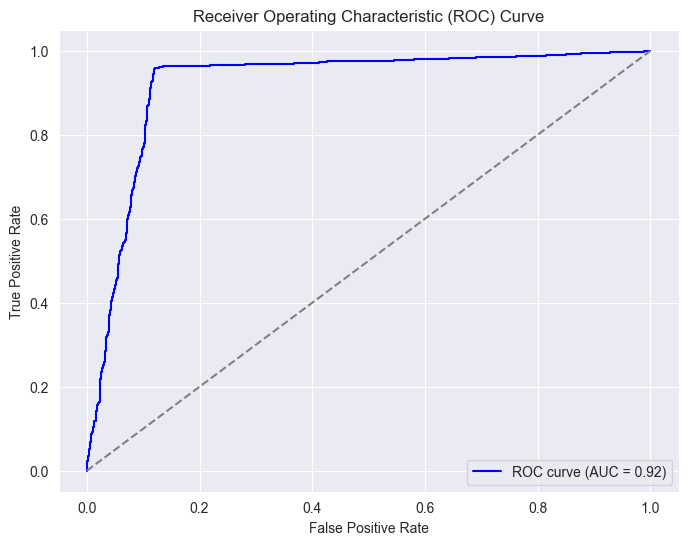

In [26]:
y_test_proba = ensemble_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


From the graph, we can see that the model has an AUC of 92, which suggests good performance. Additionally, based on the shape of the ROC curve, the model has high true positivity rate and low false positivity rate. The model has a good balance between specificity and sensitivity.

### 3.4 a)
Missing values:
- In numeric attributes, the missing values were imputed by SimpleImputer with median.
- In categorical attributed, we treated missing values by SimpleImputer with the most frequent value.
- We chose these strategies in Phase 2 of the project, because they contributed to the best performance. This is why we chose them in this phase too, since they improve the accuracy of the model. 

Outlier treatment:
- We treated outliers with a custom replacement function. This function was used to replace outliers outside the .3 and .7 quantiles. We calculate the mean value to replace these outliers.
- We chose to not use this function in the final model, since it ended up performing better without it.

### 3.4 b) Data transformation

Scaling:
- For scaling we used MinMaxScaler, which transforms the values to [0,1] range

Transformation:
- We used polynomial feature transformation (degree 2). This transformation can show additional interaction between features, and we found that it increases the accuracy of the model by around 0.05 . 

Encoding: 
- We used OneHotEncoder for categorical data. This ensures that the categorical data is correctly processed while the model is calculating the prediction.
- We decided for this implementation in Phase 2 of the project.

### 3.4 c)

Feature Selection:
- We chose Recursive Feature Elimination (RFE) with Logistic Regression selecting 10 features as the feature selection method. This is the same method we chose in the previous phase of the project, and we kept it in this phase too, since it performed the best on accuracy of the model.

Algorithms:
- We chose Logistic Regression and SVM as classification algorithms, because they proved to perform better for our task than other algorithms.

Hyperparameter tuning:
- By testing we found out that for Logistic Regression the best performing hyperparameters were max iteration of 200, regularization strength C 1, l2 as a regularization penalty and liblinear as a optimization algorithm. We tested the hyperparameters in previous part of this project and these performed the best.
- For SVM we chose a regularization parameter C of 10, scale as gamma, radial basis function (rbf) for kernel, and enabled probability estimation, which is useful when building the ensemble model.

Ensemble Learning:
- We decided to use an ensemble learning that consisted of SVM and Logistic Regression with VotingClassifier as a part of our final model. This combined the results of the models and increased the accuracy of the SVM and LR models by themselves by around 0.05 .

### 3.4 d)
The following is the pipeline with the best model for deployment

### 3.4 e) 
This is the data pipeline that can be used in production to build the model. We will export the pipeline to a pkl file.

In [4]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')),    
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Predefined classifiers with optimal hyperparameters
logreg = LogisticRegression(max_iter=200, C=1, penalty='l2', solver='liblinear', random_state=78)
svm = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=78)

# Creating the ensemble model using VotingClassifier
ensemble = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('svm', svm)
    ],
    voting='soft' 
)

# Combine preprocessing feature selection and ensemble in a single pipeline
ensemble_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),
    ('classifier', ensemble)
])


# Fit the pipeline to the training data
ensemble_pipeline.fit(X_train, y_train)

# Evaluate the model
ensemble_pipeline_score = ensemble_pipeline.score(X_train, y_train)
ensemble_pipeline_predictions = ensemble_pipeline.predict(X_test)
ensemble_pipeline_accuracy = accuracy_score(y_test, ensemble_pipeline_predictions)


print("Final model Evaluation:")
print("Training Accuracy:")
print(ensemble_pipeline_score)
print("Test Accuracy:")
print(ensemble_pipeline_accuracy)

# Save the pipeline
pipeline_filename = 'pipeline.pkl'
joblib.dump(ensemble_pipeline, pipeline_filename)

Final model Evaluation:
Training Accuracy:
0.9204922678325642
Test Accuracy:
0.927461139896373


['pipeline.pkl']

The final model has a training accuracy of 0.92 and test accuracy of 0.927, which suggests that it is not overfitting or underfitting.